In [17]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs') #path where to find the lsst util
from opsimUtils import *

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils import m52snr, radec2pix
from lsst.sims.photUtils import Bandpass, SignalToNoise, PhotometricParameters,calcGamma, calcMagError_m5

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from pylab import cm
import time
from itertools import groupby

from SNclassification_metric import *
%matplotlib inline

In [18]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_redshift_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [19]:
surveyDuration = 10 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint+='and note like "DD%"'

In [100]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [5]:
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [101]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])}
slicer = slicers.UserPointsSlicer(coo['ra'], coo['dec'], latLonDeg=True, badval=0)
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter','visitExposureTime','visitTime','note'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['visitExposureTime', 'fiveSigmaDepth', 'night', 'visitTime', 'note', 'fieldRA', 'observationStartMJD', 'filter', 'fieldDec']
Found 5722 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [102]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [103]:
df

,visitExposureTime,fiveSigmaDepth,night,visitTime,note,fieldRA,observationStartMJD,filter,fieldDec
0,30.0,23.789254,500,31.0,DD:COSMOS,150.353768,60353.159656,i,1.549694
1,30.0,23.515029,519,31.0,DD:COSMOS,150.626169,60372.110274,i,2.642504
2,30.0,23.492588,496,31.0,DD:COSMOS,150.553481,60349.152259,r,1.841210
3,30.0,23.425698,496,31.0,DD:COSMOS,150.553481,60349.152641,r,1.841210
4,30.0,23.427100,496,31.0,DD:COSMOS,150.553481,60349.153023,r,1.841210
...,...,...,...,...,...,...,...,...,...
935,30.0,23.602346,471,31.0,DD:COSMOS,149.932213,60324.218533,i,2.715372
936,30.0,23.600782,471,31.0,DD:COSMOS,149.932213,60324.218151,i,2.715372
937,30.0,23.597344,471,31.0,DD:COSMOS,149.932213,60324.217769,i,2.715372
938,30.0,24.091269,447,31.0,DD:COSMOS,149.544441,60300.316829,r,2.262656


To properly coadd the visits in the same night we operate some edits on the dataframe:

In [104]:
keygroup = ['filter', 'night']

df.sort_values(by=keygroup, ascending=[
                 True, True], inplace=True)

coadd_df = df.groupby(keygroup).agg({'visitExposureTime': ['sum'],
                                       'visitTime': ['sum'],
                                       'observationStartMJD': ['mean'],
                                       'fieldRA': ['mean'],
                                       'fieldDec': ['mean'],
                                       'fiveSigmaDepth': ['mean']}).reset_index()

coadd_df.columns = ['filter','night', 'visitExposureTime','visitTime',
                    'observationStartMJD', 'fieldRA', 'fieldDec',
                    'fiveSigmaDepth']

coadd_df.loc[:, 'fiveSigmaDepth'] += 1.25 * \
    np.log10(coadd_df['visitTime']/30.)

coadd_df.sort_values(by=['filter', 'night'], ascending=[
                     True, True], inplace=True)

In [105]:
coadd_df

,filter,night,visitExposureTime,visitTime,observationStartMJD,fieldRA,fieldDec,fiveSigmaDepth
0,g,441,300.0,310.0,60294.289211,150.158401,2.059202,25.762180
1,g,443,300.0,310.0,60296.285020,149.724031,2.308126,25.785715
2,g,447,300.0,310.0,60300.297483,149.544441,2.262656,25.709575
3,g,463,300.0,310.0,60316.232758,150.199818,1.721362,25.383625
4,g,465,300.0,310.0,60318.250140,150.243737,1.791352,25.493167
5,g,467,300.0,310.0,60320.231415,149.733689,1.964787,25.674395
6,g,469,300.0,310.0,60322.226843,150.327599,1.931482,26.113913
7,g,471,300.0,310.0,60324.228493,149.932213,2.715372,25.856537
8,g,473,300.0,310.0,60326.226450,149.696687,2.028689,25.941581
9,g,475,300.0,310.0,60328.233584,150.092085,2.875194,25.868386


In [ ]:
for f in ['g','r','i']:
    print(fcoadd_df['fiveSigmaDepth'][np.where(coadd_df['filter']==f)]

Text(0, 0.5, 'DEC')

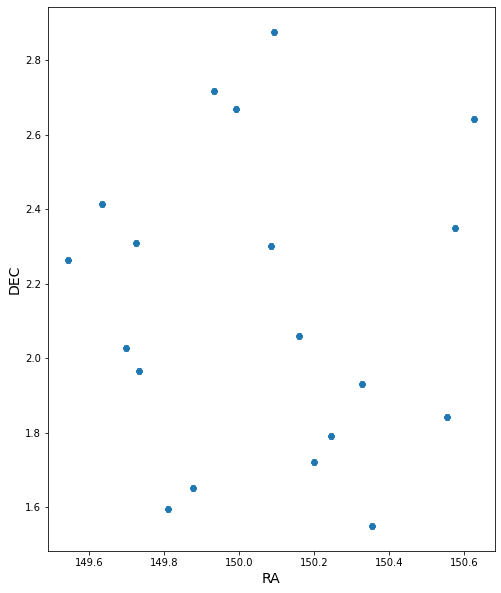

In [10]:
plt.figure(figsize=(8,10))
plt.plot(coadd_df['fieldRA'],coadd_df['fieldDec'],'H')
plt.xlabel('RA', fontsize=14)
plt.ylabel('DEC',fontsize=14)

### TEST REDSHIFT (1 SN tutti i redshift)

In [4]:
sngroups ={'II':{'II':(['1991T'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=1,zstep=0.1,
                             coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

Reading SN light curve templates
z_range = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [5]:
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], outDir, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['night', 'visitExposureTime', 'fieldRA', 'observationStartMJD', 'filter', 'fieldDec', 'visitTime', 'fiveSigmaDepth']
Found 5722 visits
Running:  ['test']
['./template/snlc_1991T_z=0.9_temp.ascii', '1991T', '0.9']
['./template/snlc_1991T_z=0.1_temp.ascii', '1991T', '0.1']
['./template/snlc_1991T_z=0.2_temp.ascii', '1991T', '0.2']
['./template/snlc_1991T_z=0.3_temp.ascii', '1991T', '0.3']
['./template/snlc_1991T_z=0.4_temp.ascii', '1991T', '0.4']
['./template/snlc_1991T_z=0.5_temp.ascii', '1991T', '0.5']
['./template/snlc_1991T_z=0.6_temp.ascii', '1991T', '0.6']
['./template/snlc_1991T_z=0.7_temp.ascii', '1991T', '0.7']
['./template/snlc_1991T_z=0.8_temp.ascii', '1991T', '0.8']
________________________________________
z= 0.1 type=Ia
total SNe simulated: 37; 
lost SNe = 20
Detected=16 UnDetected=1 filtered_class=6 not_filtered_c

# NOT-FILTERED ANALYSIS

In [8]:
lc_list = glob.glob('LC_baseline_nexp1_v1.7_10yrs_notfiltered/*dat')

obs={l:{}for l in lc_list}
expl = []
for lobs in obs.keys():
    expl.append(float(lobs.split('_')[-1].split('.')[0]))

In [ ]:
coadd_df['fiveSigmaDepth']

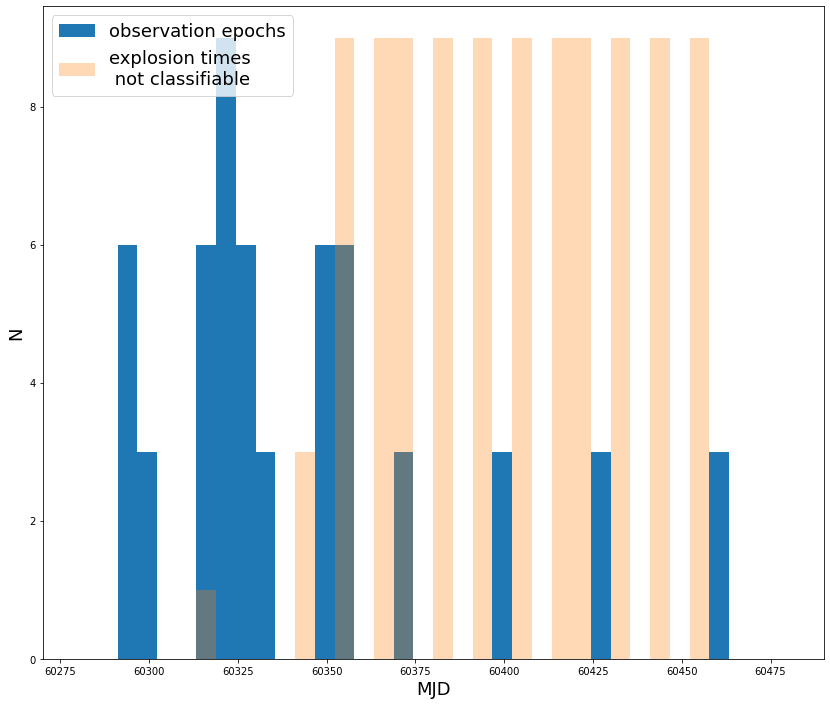

In [18]:
plt.figure(figsize=(14,12))
plt.hist(np.array(coadd_df['observationStartMJD']),bins=np.linspace(60280,60480,37),label='observation epochs')
plt.hist(expl,bins=np.linspace(60280,60480,37), label='explosion times\n not classifiable',alpha = 0.3)
plt.xlabel('MJD',fontsize=18)
plt.ylabel('N',fontsize=18)
plt.legend(fontsize=18)
plt.show()

### TEST tutte le SNe 1 redshift

In [10]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_SN_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
outDir

'/home/idies/workspace/Storage/fragosta/persistent/MAFOutput/MetricData/SNRate_SN_v1.7'

In [15]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=0.3,zstep=0.1,
                             coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

Reading SN light curve templates
z_range = [0.1 0.2]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [14]:
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], outDir, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['filter', 'night', 'visitExposureTime', 'fieldRA', 'visitTime', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth']
Found 5722 visits
Running:  ['test']
['./template/snlc_2002cx_z=0.1_temp.ascii', '2002cx', '0.1']
['./template/snlc_2004et_z=0.1_temp.ascii', '2004et', '0.1']
['./template/snlc_1999br_z=0.1_temp.ascii', '1999br', '0.1']
['./template/snlc_1999gi_z=0.1_temp.ascii', '1999gi', '0.1']
['./template/snlc_1992H_z=0.1_temp.ascii', '1992H', '0.1']
['./template/snlc_2008ax_z=0.1_temp.ascii', '2008ax', '0.1']
['./template/snlc_1987A_z=0.1_temp.ascii', '1987A', '0.1']
['./template/snlc_1998S_z=0.1_temp.ascii', '1998S', '0.1']
['./template/snlc_2005gj_z=0.1_temp.ascii', '2005gj', '0.1']
['./template/snlc_2009jf_z=0.1_temp.ascii', '2009jf', '0.1']
['./template/snlc_1994I_z=0.1_temp.ascii', '1994I', '0.1']
['./template/snlc_20

### TEST tutte le SNe tutti i  redshift

In [20]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_final_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [21]:
outDir

'/home/idies/workspace/Storage/fragosta/persistent/MAFOutput/MetricData/SNRate_final_v1.7'

In [23]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=1,zstep=0.1,
                             coo={'ra':np.random.normal(149.72403071, 2, 10),'dec':np.random.normal(2.30812595, 2, 10)})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

Reading SN light curve templates
z_range = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [24]:
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], outDir, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 4017.75 and note like "DD%" for columns ['fiveSigmaDepth', 'visitExposureTime', 'night', 'visitTime', 'fieldRA', 'fieldDec', 'observationStartMJD', 'filter']
Found 54090 visits
Running:  ['test']
['./template/snlc_1991T_z=0.1_temp.ascii', '1991T', '0.1']
['./template/snlc_1991bg_z=0.1_temp.ascii', '1991bg', '0.1']
['./template/snlc_2000cx_z=0.1_temp.ascii', '2000cx', '0.1']
['./template/snlc_1999br_z=0.1_temp.ascii', '1999br', '0.1']
['./template/snlc_1987A_z=0.1_temp.ascii', '1987A', '0.1']
['./template/snlc_1990N_z=0.2_temp.ascii', '1990N', '0.2']
['./template/snlc_2000cx_z=0.2_temp.ascii', '2000cx', '0.2']
['./template/snlc_1999gi_z=0.2_temp.ascii', '1999gi', '0.2']
['./template/snlc_2004aw_z=0.2_temp.ascii', '2004aw', '0.2']
['./template/snlc_2008ax_z=0.3_temp.ascii', '2008ax', '0.3']
['./template/snlc_2004et_z=0.4_temp.ascii', '2004et', '0.4']
['./template/sn

In [25]:
resultDbs = getResultsDbs(outDir)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, outDir)

In [26]:
bundleDicts['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys([(1, '_baseline_nexp1_v1.7_10yrs'), (2, '_baseline_nexp1_v1.7_10yrs')])

In [27]:
df17={}
coo_df={}
for opsim in  ['baseline_nexp1_v1.7_10yrs']:
    df17[opsim]={}
    coo_df[opsim]={}
    
    bmetric =[(2, '_baseline_nexp1_v1.7_10yrs')]
    for metric in bmetric:
        coo_df[opsim][metric[1]] = np.column_stack((bundleDicts[opsim][metric].slicer.slicePoints['ra'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]
                                          ,bundleDicts[opsim][metric].slicer.slicePoints['dec'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]))
        arr=bundleDicts[opsim][metric].metricValues.data
        arr_=arr[np.where(arr!=None)]
        df17[opsim][metric[1]] = pd.DataFrame.from_records(arr_)

In [14]:
lc_list = glob.glob('LC_baseline_nexp1_v1.7_10yrs/*dat')

obs={l:{}for l in lc_list}
coo = {l:[]for l in lc_list}
expl = []
for lobs in obs.keys():
    expl.append(float(lobs.split('_')[-2]))
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    loc = l[3].split()
    ra = float(loc[1])
    loc = l[4].split()
    dec = float(loc[1])
    coo[lobs].append([ra,dec])    
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs),'coo': [ra,dec]}})
    

In [27]:
lc_list[250:260]

['LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60294.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60304.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60324.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60334.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60344.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60354.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60364.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60374.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60384.28.dat']

In [15]:
temp = template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 1,z_step=0.1)
obs_template = temp.run()

Reading SN light curve templates


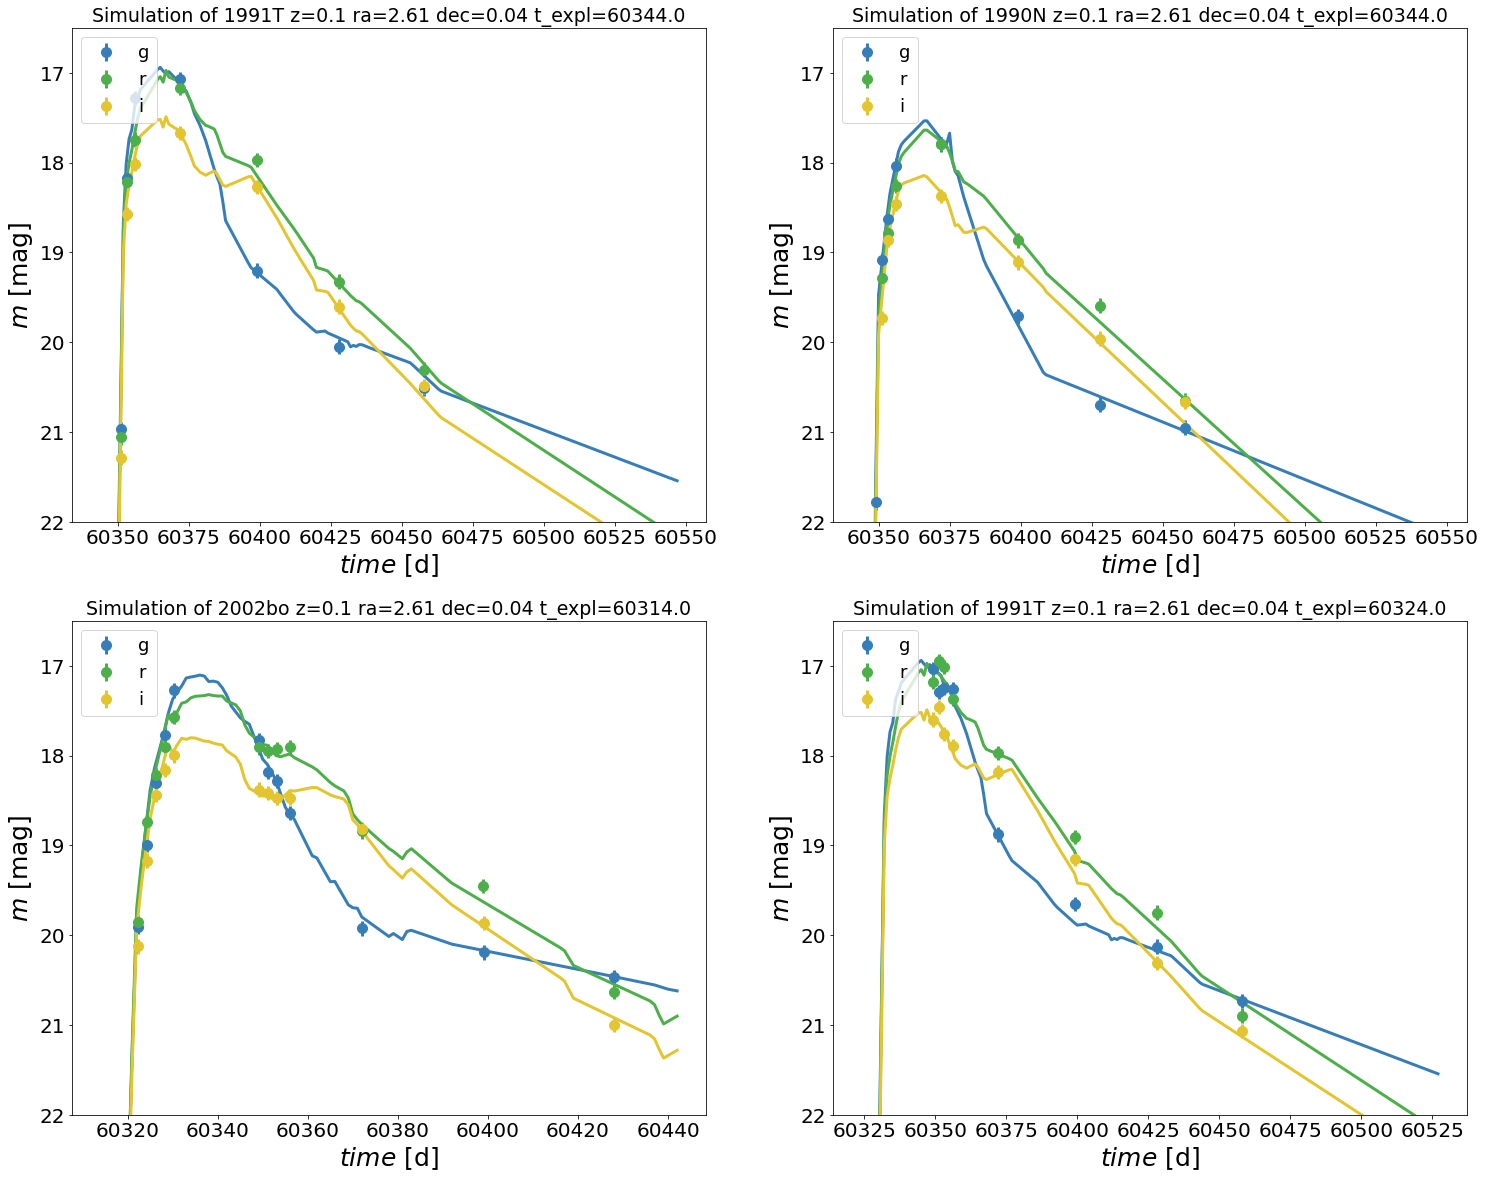

In [16]:
color = ['#377eb8','#4daf4a', '#e3c530']
ty= ['1991T','1990N','2002bo','1991T']
llist= ['LC_baseline_nexp1_v1.7_10yrs/LSST_1991T_0.1_60344.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.1_60344.28.dat',
      'LC_baseline_nexp1_v1.7_10yrs/LSST_2002bo_0.1_60314.28.dat',
      'LC_baseline_nexp1_v1.7_10yrs/LSST_1991T_0.1_60324.28.dat']
fig, axes = plt.subplots(2,2,figsize=(25,20))
for i,axs in enumerate(axes.flatten()):
    for j, f in enumerate(['g','r','i']):
        c=color[j]
        t_expl = float(llist[i].split('_')[-1].split('.')[0])
        z = float(llist[i].split('_')[-2])
        filters=obs[llist[i]][z]['filter']==f
        mag =obs_template['magobs'][ty[i]][z][f]
        maglc =obs[llist[i]][z]['mag'][filters]
        magerrlc =obs[llist[i]][z]['mag_err'][filters]
        
        if np.size(obs[llist[i]][z]['epoch'][filters])>0:
            ph = obs_template['phobs'][ty[i]][z][f]+t_expl-obs_template['phobs'][ty[i]][z][f][0]
            phlc = obs[llist[i]][z]['epoch'][filters]
            axs.errorbar(phlc, maglc,yerr=magerrlc,fmt='o',elinewidth=3,color=c,markersize=10,label=f)
            axs.plot(ph, mag,'-',lw=3,color=c)
        axs.invert_yaxis()
        axs.set_ylim([22,16.5])
        #axs.set_xlim([60200,60400])
        axs.set_xlabel(r'$time$ [d]',fontsize=25)
        axs.set_ylabel(r'$m$ [mag]',fontsize=25)
        axs.set_title(r'Simulation of {} z={} ra={} dec={} t_expl={}'.format(ty[i],z,
        np.round(obs[llist[i]][z]['coo'][0],2),np.round(obs[llist[i]][z]['coo'][1],2), t_expl),fontsize=19)
        axs.tick_params('both', labelsize=20)
    #if i ==0:
        axs.legend(loc=2,fontsize=18)


IndexError: list index out of range

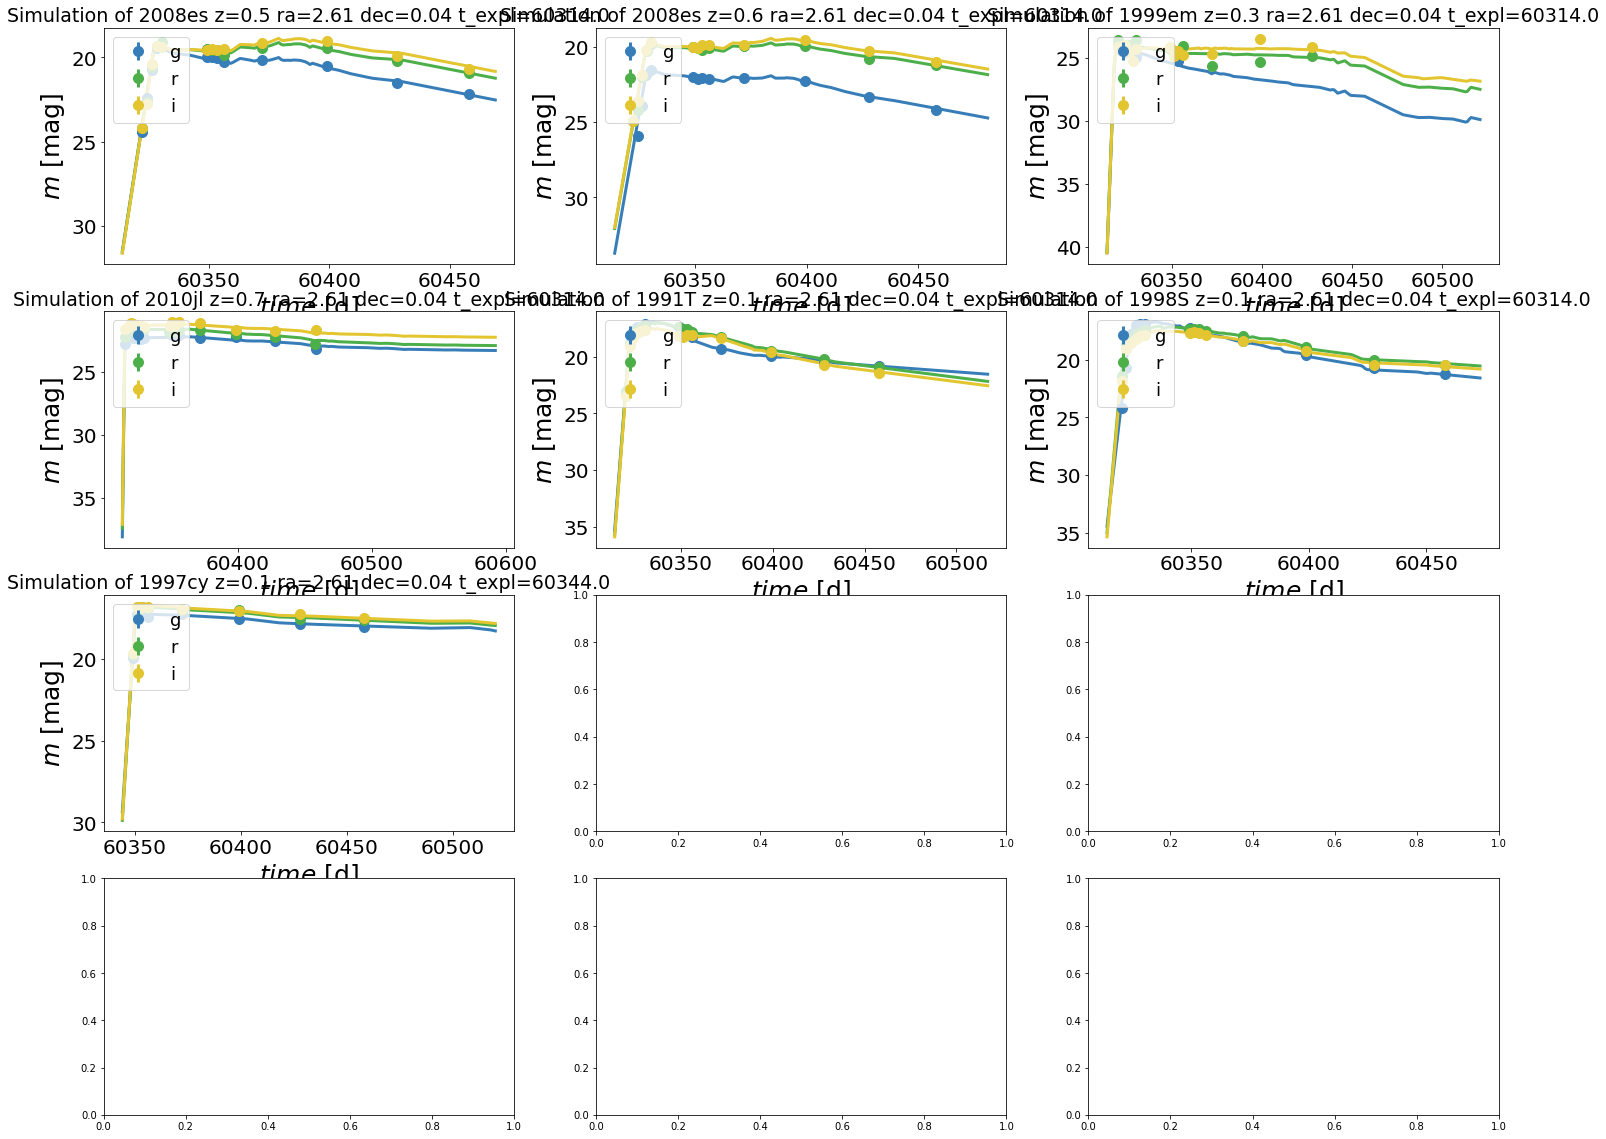

In [113]:
color = ['#377eb8','#4daf4a', '#e3c530']
ty= ['2008es','2008es','1999em','2010jl','1991T','1998S','1997cy']
llist= [ 'LC_baseline_nexp1_v1.7_10yrs/LSST_2008es_0.5_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_2008es_0.6_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1999em_0.3_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_2010jl_0.7_60314.28.dat', 
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1991T_0.1_60314.28.dat',
'LC_baseline_nexp1_v1.7_10yrs/LSST_1998S_0.1_60314.28.dat', 
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1997cy_0.1_60344.28.dat']
fig, axes = plt.subplots(4,3,figsize=(25,20))
for i,axs in enumerate(axes.flatten()):
    for j, f in enumerate(['g','r','i']):
        c=color[j]
        t_expl = float(llist[i].split('_')[-1].split('.')[0])
        z = float(llist[i].split('_')[-2])
        filters=obs[llist[i]][z]['filter']==f
        mag =obs_template['magobs'][ty[i]][z][f]
        maglc =obs[llist[i]][z]['mag'][filters]
        magerrlc =obs[llist[i]][z]['mag_err'][filters]
        
        if np.size(obs[llist[i]][z]['epoch'][filters])>0:
            ph = obs_template['phobs'][ty[i]][z][f]+t_expl-obs_template['phobs'][ty[i]][z][f][0]
            phlc = obs[llist[i]][z]['epoch'][filters]
            axs.errorbar(phlc, maglc,yerr=magerrlc,fmt='o',elinewidth=3,color=c,markersize=10,label=f)
            axs.plot(ph, mag,'-',lw=3,color=c)
        axs.invert_yaxis()
        #axs.set_ylim([22,16.5])
        #axs.set_xlim([60200,60400])
        axs.set_xlabel(r'$time$ [d]',fontsize=25)
        axs.set_ylabel(r'$m$ [mag]',fontsize=25)
        axs.set_title(r'Simulation of {} z={} ra={} dec={} t_expl={}'.format(ty[i],z,
        np.round(obs[llist[i]][z]['coo'][0],2),np.round(obs[llist[i]][z]['coo'][1],2), t_expl),fontsize=19)
        axs.tick_params('both', labelsize=20)
    #if i ==0:
        axs.legend(loc=2,fontsize=18)


In [28]:
fractions={'Ia':None,'II':None,'Ibc':None}

for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        o=[]
        
        for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):
            
            o.append(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][i][k][key][key])
            
        
        c+=np.array(o)
        
    fractions[key]=c/slicer.slicePoints['zrange'].size

In [29]:
detected = []

for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):

    det=0
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        det+=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']/(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']+
        df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['UnDetected'])

    detected.append(det/slicer.slicePoints['zrange'].size)
detected = pd.DataFrame(detected)

In [30]:
zfractions={'Ia':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'II':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'Ibc':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        for i in range(len(c)):             
                c[i]=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k][key][key]
        zfractions[key][k]=np.array(c)

In [33]:
missclass={'Ia':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'II':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'Ibc':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = []#np.empty(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    if key=='Ia':
        c.append(np.array([np.array([0,0,0],dtype=[('IaIa',np.float32),('IaIbc',np.float32),('IaII',np.float32)])]))
    if key=='II':
        c.append(np.array([np.array([0,0,0],dtype=[('IIIa',np.float32),('IIIbc',np.float32),('IIII',np.float32)])]))
    if key=='Ibc':
        c.append(np.array([np.array([0,0,0],dtype=[('IbcIa',np.float32),('IbcIbc',np.float32),('IbcII',np.float32)])]))
   
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        #for i in range(len(c)):
        if key=='Ia':
            c[0]['IaIa']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k][key][key]
            c[0]['IaII']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['II'][key]
            c[0]['IaIbc']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['Ibc'][key]
        if key=='Ibc':
            c[0]['IbcIa']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['Ia'][key]
            c[0]['IbcII']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['II'][key]
            c[0]['IbcIbc']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k][key][key]
        if key=='II':
            c[0]['IIIa']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['Ia'][key]
            c[0]['IIII']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k][key][key]
            c[0]['IIIbc']=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][0][k]['Ibc'][key]
        
        missclass[key][k]=np.array(c)

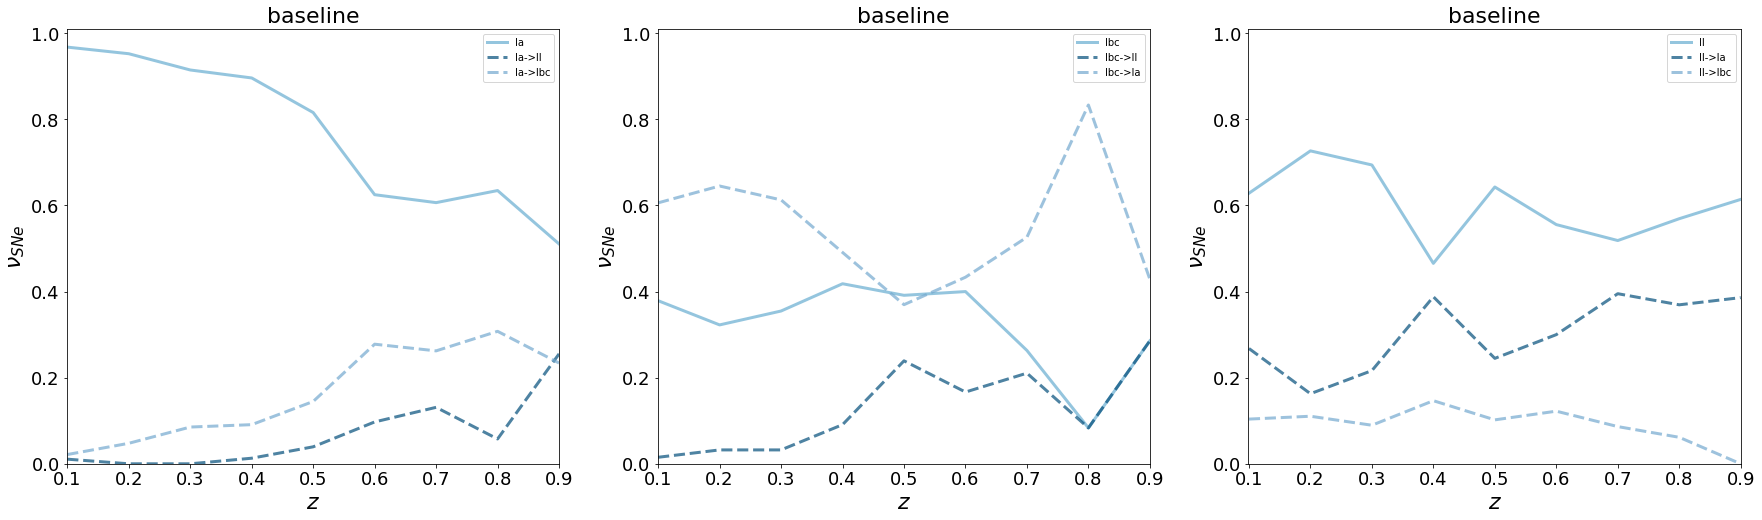

In [34]:
fig, axes = plt.subplots(1,3,figsize=(30,8))
for i, (t,ax) in enumerate(zip(['Ia','Ibc','II'], axes.flatten())):
    if t =='Ia':
        ax.plot(zfractions[t].keys(),np.concatenate([ zfractions[t][k] for k in zfractions[t].keys()]),'-',color='#2b8cbe',lw=3,alpha=0.5,label= 'Ia' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['Ia'][k]['IaII'][0]) for k in zfractions[t].keys()]),'--',color='#034e7b',lw=3,alpha=0.7,label= 'Ia->II' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['Ia'][k]['IaIbc'][0]) for k in zfractions[t].keys()]),'--',color = '#74a9cf',lw=3,alpha=0.7,label= 'Ia->Ibc' )
        ax.legend()
    if t =='II':
        ax.plot(zfractions[t].keys(),np.concatenate([ zfractions[t][k] for k in zfractions[t].keys()]),'-',color='#2b8cbe',lw=3,alpha=0.5,label= 'II' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['II'][k]['IIIa'][0]) for k in zfractions[t].keys()]),'--',color='#034e7b',lw=3,alpha=0.7,label= 'II->Ia' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['II'][k]['IIIbc'][0]) for k in zfractions[t].keys()]),'--',color = '#74a9cf',lw=3,alpha=0.7,label= 'II->Ibc' )
        ax.legend()
    if t =='Ibc':
        ax.plot(zfractions[t].keys(),np.concatenate([ zfractions[t][k] for k in zfractions[t].keys()]),'-',color='#2b8cbe',lw=3,alpha=0.5,label= 'Ibc' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['Ibc'][k]['IbcII'][0]) for k in zfractions[t].keys()]),'--',color='#034e7b',lw=3,alpha=0.7,label= 'Ibc->II' )
        ax.plot(zfractions[t].keys(),np.concatenate([ np.unique(missclass['Ibc'][k]['IbcIa'][0]) for k in zfractions[t].keys()]),'--',color = '#74a9cf',lw=3,alpha=0.7,label= 'Ibc->Ia' )    
        ax.legend()
    ax.set_ylabel(r'$\nu_{SNe}$', fontsize=22)
    ax.set_xlabel(r'$z$', fontsize=22)
    ax.set_xlim([0,1])
    ax.set_xlim([0.099,0.9])
    ax.tick_params('both', labelsize=18)
    #axes.legend(loc=1,bbox_to_anchor=(1.2, .5, 0.5, 0.5),fontsize=16)
    ax.set_title('baseline', fontsize=22)
    ax.set_ylim([0,1.01])
    

In [35]:
from util_snrmetric.util_snratemetric import plt_mlw

In [50]:
detected[key]

0    0.692596
Name: Ia, dtype: float64

# Sky map detected SNe

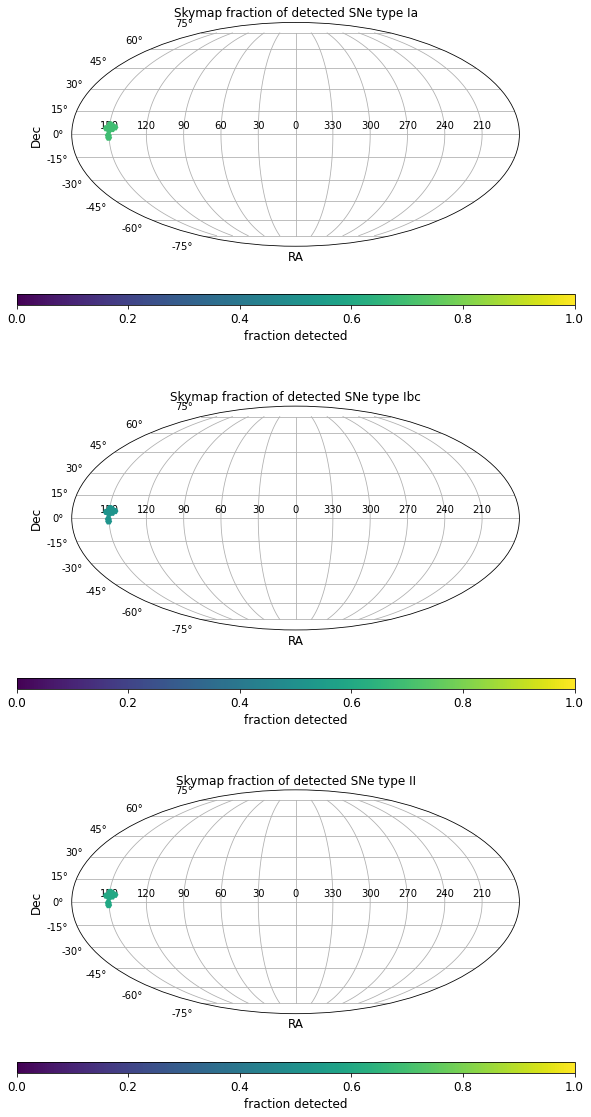

In [51]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia','Ibc','II']):
    ax= fig.add_subplot(3,1,i+1, projection='mollweide')
    plt_mlw(ax,np.degrees(slicer.slicePoints['ra']),np.degrees(slicer.slicePoints['dec']),c=np.ones(len(slicer.slicePoints['dec']))*np.array(detected[key]),vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction detected','colormap':'viridis','title': 'Skymap fraction of detected SNe type {}'.format(key),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

# Sky map classifiable SNe

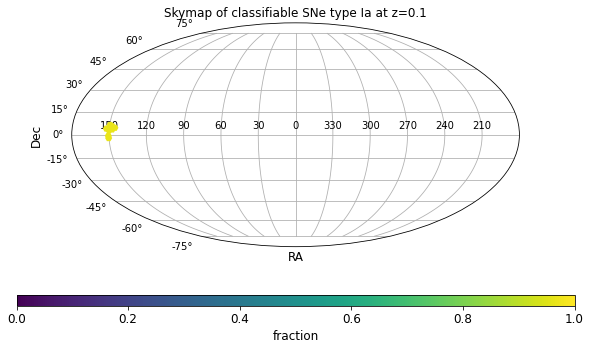

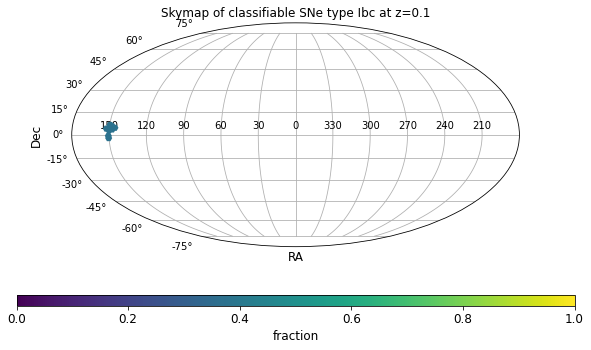

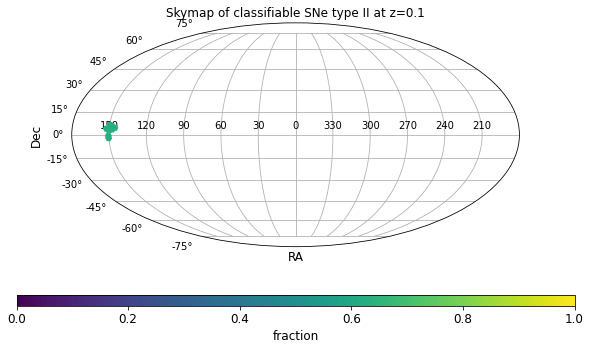

In [52]:
for i, key in enumerate(['Ia','Ibc','II']):
    fig=plt.figure(figsize=(10,20))
    for j, z in enumerate([0.1]):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,np.degrees(slicer.slicePoints['ra']),np.degrees(slicer.slicePoints['dec']),c=np.ones(len(slicer.slicePoints['dec']))*np.array(zfractions[key][z]),vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction','colormap':'viridis','title': 'Skymap of classifiable SNe type {} at z={}'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')